Name: Aravindh Palaniguru UCID: 30301478

**About Dataset**

Historical stock data of SNP500 index from 19/09/2005 to 19/09/2025 was downloaded using the yfinance library, which provides programmatic access to Yahoo Finance's comprehensive financial database.

Dataset consists of:

1.   Time Period: Historical daily data
2.   Data Fields: 5 standard financial metrics per trading day:

*  Date: Trading date (Date/DateTime)
*  Open: Opening price (Numeric/Float)
*  High: Highest price during the trading day (Numeric/Float)
*  Low: Lowest price during the trading day (Numeric/Float)
*  Close: Closing price (Numeric/Float)
*  Volume: Number of shares traded per day (Numeric/Integer)

Prices appear in US dollar values.
Volume is in absolute number of shares that are traded per day



Below cell that connects Google colab to Googgle drive to access the dataset uploaded to google drive

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


Dataset of current top 4 equities of SNP500 index as mentioned in the cell loaded from local CSVs: NVDA, AAPL, MSFT, AMZN, with one file per ticker in the specified Drive folder.

Variables retained: Date (datetime), price fields Open/High/Low/Close/Adj Close (numeric where present), Volume (integer/numeric), and Stock (categorical).

For each stock symbol, the pipeline does the following:

**Data Loading Process:**
* File existence check: Verified CSV files exist using `os.path.exists()`
* Data structure validation: Confirmed presence of required 'Date' column with `if 'Date' in df.columns`
* Error handling: Print statements for missing files or missing Date column
* Stock labeling: Added categorical 'Stock' column with `df['Stock'] = stock`

**Cleaning Applied:**
* Date parsing: Converted 'Date' columns to datetime using `pd.to_datetime(df['Date'], errors='coerce')`
* Ordering: Sorted datasets by date using `df.sort_values('Date')`
* Missing value removal: Removed rows with any NaN using `df.dropna(how='any')`
* Index reset: Reset indices using `reset_index(drop=True)`
* Combined all stock datasets using `pd.concat(stock_data.values(), ignore_index=True)`

**Confirmation:**
* Row counts printed for each loaded stock
* Final dataset shape displayed
* Date range coverage shown from min to max dates

In [2]:
# Import Libraries and Load Data

import os
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import (accuracy_score, classification_report,
                             confusion_matrix, precision_recall_fscore_support)
from sklearn.preprocessing import StandardScaler
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC

# Folder path
folder_path = '/content/drive/MyDrive/SNP500/stock_data/'

# List of stocks to process
stocks = ['NVDA', 'AAPL', 'MSFT', 'AMZN']

stock_data = {}

for stock in stocks:
    file_path = f'{folder_path}{stock}.csv'
    if os.path.exists(file_path):
        df = pd.read_csv(file_path)
        # Ensure 'Date' exists and then parse and tag
        if 'Date' in df.columns:
            df['Date'] = pd.to_datetime(df['Date'], errors='coerce')
            df['Stock'] = stock
            # Sort, drop any row with any NaN, then reset index (only once needed here)
            df = df.sort_values('Date').dropna(how='any').reset_index(drop=True)
            stock_data[stock] = df
            print(f"Loaded {stock}: {len(df)}")
        else:
            print(f"Failed to load {stock}: 'Date' column missing")
    else:
        print(f"Failed to load {stock}: file not found")

# Combine all stock data
if stock_data:
    # Concatenate with ignore_index=True (creates clean 0-based index automatically)
    combined_df = pd.concat(stock_data.values(), ignore_index=True)

    # Clean and sort data
    combined_df = combined_df.dropna(how='any').sort_values(['Date', 'Stock'])

    # Add previous close column
    combined_df['Prev_Close'] = combined_df.groupby('Stock')['Close'].shift(1)

    # Eemove rows where Prev_Close is NaN and reset index once
    combined_df = combined_df.dropna(how='any').reset_index(drop=True)

else:
    print("\nNo stock data was loaded.")

Loaded NVDA: 5033
Loaded AAPL: 5033
Loaded MSFT: 5033
Loaded AMZN: 5033


In [3]:
combined_df #to see visually the dataframe created

Date        Open        High         Low       Close     Volume  \
0     2005-09-20    1.590766    1.615383    1.588665    1.596771  819828800   
1     2005-09-20    2.132500    2.150500    2.088500    2.093500   69440000   
2     2005-09-20   18.158935   18.263416   17.894248   17.998730   61043400   
3     2005-09-20    0.252373    0.258179    0.252067    0.255353  522192000   
4     2005-09-21    1.589866    1.592567    1.556843    1.564348  434747600   
...          ...         ...         ...         ...         ...        ...   
20123 2025-09-18  173.979996  177.100006  172.960007  176.240005  191763300   
20124 2025-09-19  241.229996  246.300003  240.210007  245.500000  163470300   
20125 2025-09-19  232.369995  234.160004  229.699997  231.479996   97810200   
20126 2025-09-19  510.559998  519.299988  510.309998  517.929993   52371500   
20127 2025-09-19  175.770004  178.080002  175.179993  176.669998  236658800   

      Stock  Prev_Close  
0      AAPL    1.580259  
1      AMZN    2.137500  
2      MSFT   18.110184  
3      NVDA    0.250463  
4      AAPL    1.596771  
...     ...         ...  
20123  NVDA  170.289993  
20124  AAPL  237.880005  
20125  AMZN  231.229996  
20126  MSFT  508.450012  
20127  NVDA  176.240005  

[20128 rows x 8 columns]

This cell reports the dataset shape to show the number of rows and columns in scope.
It then lists each column’s inferred type as Date/Time, Categorical, Numeric (Financial), or Numeric (Count), along with the count of missing values for basic data health.
Volume is handled as a count variable, while price fields (Open, High, Low, Close, Adj Close) are treated as numeric financial measures for analysis.
The stock distribution prints row counts per ticker to confirm coverage and quickly spot any imbalance across symbols.

In [4]:

# Data Types Analysis
print("Dataset Info:")
print(f"Shape: {combined_df.shape}")

print("\nData Types:")
for col in combined_df.columns:
    dtype = combined_df[col].dtype
    null_count = combined_df[col].isna().sum()

    if 'object' in str(dtype):
        category = "Categorical"
    elif 'datetime' in str(dtype):
        category = "Date/Time"
    elif col == 'Volume':
        category = "Numeric (Count)"
    else:
        category = "Numeric (Financial)"

    print(f"{col}: {category} | Missing: {null_count}")

print(f"\nStock distribution:")
print(combined_df['Stock'].value_counts())

Dataset Info:
Shape: (20128, 8)

Data Types:
Date: Date/Time | Missing: 0
Open: Numeric (Financial) | Missing: 0
High: Numeric (Financial) | Missing: 0
Low: Numeric (Financial) | Missing: 0
Close: Numeric (Financial) | Missing: 0
Volume: Numeric (Count) | Missing: 0
Stock: Categorical | Missing: 0
Prev_Close: Numeric (Financial) | Missing: 0

Stock distribution:
Stock
AAPL    5032
AMZN    5032
MSFT    5032
NVDA    5032
Name: count, dtype: int64


This cell reports count, mean, median, standard deviation, min/max, and quartiles for Open, High, Low, Close, and Volume using pandas' built-in statistical functions (len(), data.mean(), data.median(), data.std(), data.min(), data.max(), data.quantile()). Quartiles and the range help flag potential outliers, while a noticeable gap between mean and median can indicate skew.

In [5]:
# Summary Statistics - Overall and Per Stock
key_vars = ['Open', 'High', 'Low', 'Close', 'Volume']

print("="*80)
print("SUMMARY STATISTICS - OVERALL DATASET")
print("="*80)
for var in key_vars:
    data = combined_df[var]
    stats = {
        'count': len(data),
        'mean': data.mean(),
        'median': data.median(),
        'std': data.std(),
        'min': data.min(),
        'max': data.max(),
        'q1': data.quantile(0.25),
        'q3': data.quantile(0.75)
    }

    print(f"\n{var}:")
    for stat, val in stats.items():
        if stat == 'count':
            print(f"  {stat}: {val:.0f}")
        else:
            print(f"  {stat}: {val:.2f}")

print("\n" + "="*80)
print("SUMMARY STATISTICS - BY STOCK")
print("="*80)

stocks = combined_df['Stock'].unique()

for stock in stocks:
    print(f"\n{'='*80}")
    print(f"{stock}")
    print(f"{'='*80}")

    stock_data = combined_df[combined_df['Stock'] == stock]

    for var in key_vars:
        data = stock_data[var]
        stats = {
            'count': len(data),
            'mean': data.mean(),
            'median': data.median(),
            'std': data.std(),
            'min': data.min(),
            'max': data.max(),
            'q1': data.quantile(0.25),
            'q3': data.quantile(0.75)
        }

        print(f"\n{var}:")
        for stat, val in stats.items():
            if stat == 'count':
                print(f"  {stat}: {val:.0f}")
            else:
                print(f"  {stat}: {val:.2f}")

# Comparative summary table
print("\n" + "="*80)
print("COMPARATIVE SUMMARY - KEY METRICS BY STOCK")
print("="*80)

summary_data = []
for stock in stocks:
    stock_data = combined_df[combined_df['Stock'] == stock]
    summary_data.append({
        'Stock': stock,
        'Avg Close': f"${stock_data['Close'].mean():.2f}",
        'Med Close': f"${stock_data['Close'].median():.2f}",
        'Std Close': f"${stock_data['Close'].std():.2f}",
        'Avg Volume': f"{stock_data['Volume'].mean()/1e6:.1f}M",
        'Med Volume': f"{stock_data['Volume'].median()/1e6:.1f}M",
        'Price Range': f"${stock_data['Close'].min():.2f} - ${stock_data['Close'].max():.2f}"
    })

summary_df = pd.DataFrame(summary_data)
print("\n" + summary_df.to_string(index=False))

SUMMARY STATISTICS - OVERALL DATASET

Open:
  count: 20128
  mean: 63.33
  median: 21.11
  std: 91.45
  min: 0.14
  max: 554.32
  q1: 4.63
  q3: 91.14

High:
  count: 20128
  mean: 64.01
  median: 21.32
  std: 92.33
  min: 0.15
  max: 554.54
  q1: 4.70
  q3: 92.10

Low:
  count: 20128
  mean: 62.62
  median: 20.86
  std: 90.53
  min: 0.13
  max: 531.03
  q1: 4.57
  q3: 90.26

Close:
  count: 20128
  mean: 63.35
  median: 21.09
  std: 91.47
  min: 0.14
  max: 534.76
  q1: 4.63
  q3: 91.13

Volume:
  count: 20128
  mean: 258457765.55
  median: 110475800.00
  std: 320485302.21
  min: 7164500.00
  max: 3692928000.00
  q1: 51468450.00
  q3: 380759000.00

SUMMARY STATISTICS - BY STOCK

AAPL

Open:
  count: 5032
  mean: 58.98
  median: 24.91
  std: 69.44
  min: 1.46
  max: 257.28
  q1: 8.34
  q3: 111.62

High:
  count: 5032
  mean: 59.63
  median: 25.12
  std: 70.20
  min: 1.51
  max: 259.18
  q1: 8.46
  q3: 112.93

Low:
  count: 5032
  mean: 58.38
  median: 24.67
  std: 68.76
  min: 1.44
  m

The dataset is sorted by Stock and Date to ensure time-series calculations occur in proper chronological order within each ticker.

**Continuous Features:**
- **Daily_Return** calculates the percent day-over-day change in closing price using `pct_change()`
- **Daily_Volatility** measures intraday price range as (High - Low)/Open × 100, providing a normalized volatility metric
- **Price_Change** captures the absolute dollar difference in closing prices to show direction and magnitude
- **Volume_Change** tracks percent change in trading activity between consecutive days
- **Price_Position** places the closing price within the day's trading range on a 0-100 scale; defaults to 50 when High equals Low to prevent division by zero

**Categorical Features (Binned):**
- **Return_Category** bins daily returns into three groups: Negative (< -0.4%), Neutral (-0.4% to +0.4%), and Positive (> +0.4%) using `pd.cut()`
- **Volatility_Level** categorizes intraday volatility as Low (0-2%), Medium (2-4%), or High (> 4%) based on the Daily_Volatility values
- **Price_Change_Category** creates binary Up/Down labels based on whether the price change is positive or negative

The binning approach using `pd.cut()` with specified breakpoints transforms continuous variables into categorical ones, enabling straightforward distribution analysis and visualization across different market conditions. Finally, `dropna()` removes any incomplete records to ensure clean data for analysis.

In [6]:
# Data Preprocessing and Feature Engineering
# Sort data properly

combined_df = combined_df.sort_values(['Stock', 'Date']).reset_index(drop=True)

combined_df['Daily_Return'] = combined_df.groupby('Stock')['Close'].pct_change() * 100
combined_df['Daily_Volatility'] = ((combined_df['High'] - combined_df['Low']) / combined_df['Open'] * 100)
combined_df['Price_Change'] = combined_df.groupby('Stock')['Close'].diff()
combined_df['Volume_Change'] = combined_df.groupby('Stock')['Volume'].pct_change() * 100

price_range = combined_df['High'] - combined_df['Low']
combined_df['Price_Position'] = np.where(
    price_range > 0,
    ((combined_df['Close'] - combined_df['Low']) / price_range * 100),
    50
)

combined_df['Return_Category'] = pd.cut(
    combined_df['Daily_Return'],
    bins=[-np.inf, -0.4, 0.4, np.inf],
    labels=['Negative', 'Neutral', 'Positive']
)

combined_df['Volatility_Level'] = pd.cut(
    combined_df['Daily_Volatility'],
    bins=[0, 2, 4, np.inf],
    labels=['Low', 'Medium', 'High']
)

combined_df['Price_Change_Category'] = pd.cut(
    combined_df['Price_Change'],
    bins=[-np.inf, 0, np.inf],
    labels=['Down', 'Up']
)


# Remove rows with any NaN values
combined_df = combined_df.dropna().reset_index(drop=True)
display(combined_df.head(20))
print(f"Features created. Dataset shape: {combined_df.shape}")
print(f"New features: Daily_Return, Daily_Volatility, Price_Change, Volume_Change, MA_5, Price_Position")

Date      Open      High       Low     Close      Volume Stock  \
0  2005-09-21  1.589866  1.592567  1.556843  1.564348   434747600  AAPL   
1  2005-09-22  1.557443  1.575156  1.540632  1.558043   463727600  AAPL   
2  2005-09-23  1.564048  1.606076  1.556243  1.597070   558457200  AAPL   
3  2005-09-26  1.621987  1.637897  1.600673  1.616283   546562800  AAPL   
4  2005-09-27  1.618684  1.628291  1.603974  1.604275   341703600  AAPL   
5  2005-09-28  1.593167  1.594369  1.518718  1.533428  1125544000  AAPL   
6  2005-09-29  1.537930  1.578757  1.525322  1.571253   636846000  AAPL   
7  2005-09-30  1.570953  1.610579  1.557443  1.609379   531633200  AAPL   
8  2005-10-03  1.625890  1.637298  1.611480  1.634296   507553200  AAPL   
9  2005-10-04  1.649606  1.661614  1.610279  1.613582   539459200  AAPL   
10 2005-10-05  1.630993  1.631894  1.583561  1.584462   610769600  AAPL   
11 2005-10-06  1.597070  1.605776  1.527124  1.552040   757537200  AAPL   
12 2005-10-07  1.552641  1.558945  1.517517  1.540032   677882800  AAPL   
13 2005-10-10  1.553841  1.558344  1.509411  1.512113   507505600  AAPL   
14 2005-10-11  1.537931  1.557143  1.513014  1.548738  1225884800  AAPL   
15 2005-10-12  1.460479  1.510012  1.437063  1.478491  2697486400  AAPL   
16 2005-10-13  1.484194  1.619585  1.479091  1.613281  1865575600  AAPL   
17 2005-10-14  1.621987  1.631593  1.584761  1.621086  1035552000  AAPL   
18 2005-10-17  1.620486  1.627991  1.581460  1.604275   616834400  AAPL   
19 2005-10-18  1.598571  1.619585  1.567050  1.567350   609588000  AAPL   

    Prev_Close  Daily_Return  Daily_Volatility  Price_Change  Volume_Change  \
0     1.596771     -2.030522          2.246973     -0.032423     -46.970929   
1     1.564348     -0.403004          2.216685     -0.006304       6.665937   
2     1.558043      2.504863          3.186145      0.039027      20.427855   
3     1.597070      1.202998          2.294981      0.019213      -2.129868   
4     1.616283     -0.742966          1.502248     -0.012008     -37.481365   
5     1.604275     -4.416127          4.748448     -0.070847     229.391906   
6     1.533428      2.466703          3.474502      0.037825     -43.418827   
7     1.571253      2.426456          3.382368      0.038126     -16.520917   
8     1.609379      1.548253          1.587875      0.024917      -4.529439   
9     1.634296     -1.267475          3.111949     -0.020714       6.286238   
10    1.613582     -1.804679          2.963372     -0.029120      13.218868   
11    1.584462     -2.046199          4.924787     -0.032421      24.029945   
12    1.552040     -0.773703          2.668229     -0.012008     -10.514916   
13    1.540032     -1.812865          3.149191     -0.027919     -25.133725   
14    1.512113      2.422061          2.869413      0.036624     141.550990   
15    1.548738     -4.535723          4.994880     -0.070246     120.044037   
16    1.478491      9.116714          9.466028      0.134790     -30.840222   
17    1.613281      0.483759          2.887270      0.007804     -44.491555   
18    1.621086     -1.037022          2.871432     -0.016811     -40.434242   
19    1.604275     -2.301616          3.286385     -0.036924      -1.174772   

    Price_Position Return_Category Volatility_Level Price_Change_Category  
0        21.006970        Negative           Medium                  Down  
1        50.433480        Negative           Medium                  Down  
2        81.927897        Positive           Medium                    Up  
3        41.935293        Positive           Medium                    Up  
4         1.234166        Negative              Low                  Down  
5        19.444485        Negative             High                  Down  
6        85.955760        Positive           Medium                    Up  
7        97.740996        Positive           Medium                    Up  
8        88.373284        Positive              Low                    Up  
9         6.4

Features created. Dataset shape: (20124, 16)
New features: Daily_Return, Daily_Volatility, Price_Change, Volume_Change, MA_5, Price_Position


This plot plotted using matplotlib shows each ticker’s Close over time on the same axes to compare levels and trends.
Titles, axis labels with units, a legend keyed by ticker, and a light grid are included to keep the time series readable.
Lines are drawn in date order for each stock across the full sample period.


Line plots was used for stock price evolution since it is appropriate for time-series data to show trends over time


In [7]:

plt.figure(figsize=(12, 6))

# Stock price evolution
for stock in combined_df['Stock'].unique():
    stock_data = combined_df[combined_df['Stock'] == stock].sort_values('Date')
    plt.plot(stock_data['Date'], stock_data['Close'], label=stock, linewidth=1)

plt.title('Stock Price Evolution', fontsize=16)
plt.xlabel('Date', fontsize=12)
plt.ylabel('Price ($)', fontsize=12)
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

**Interpretation of Stock Price Evolution graph**

**Price Levels & Growth Trajectories:**
- **NVDA (purple)** shows the most dramatic growth, remaining relatively flat until ~2023, then experiencing strong growth (possibly due to AI boom)
- **MSFT (red)** shows steady appreciation with notable acceleration after 2016
- **AAPL (blue)** and **AMZN (orange)** show more moderate but consistent growth trajectories

- All stocks show synchronized major dips around 2020 (possibly due to COVID), and 2022 (possibly due to Ukraine-Russia war)


**Interpretation:**

All 4 tech stocks (AAPL, AMZN, MSFT, NVDA) show similar patterns with positive days higher and significant amount of negative days and least neutral days.

This is subject to the limits set in the code for calculating them.


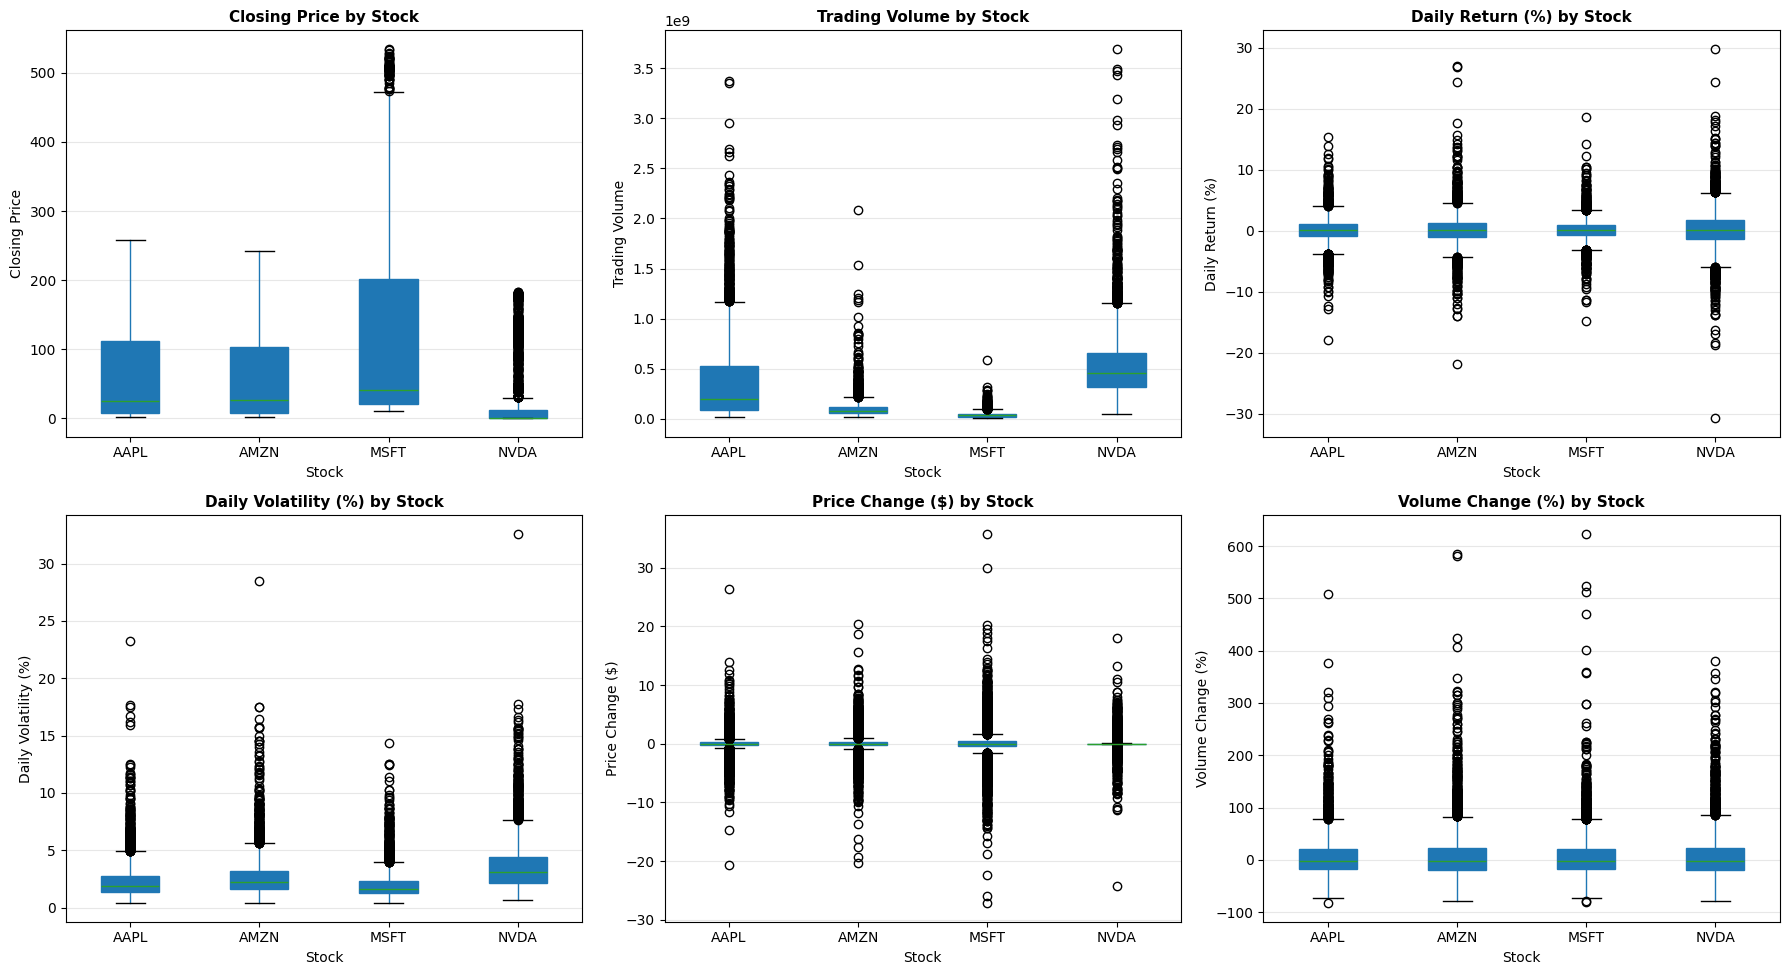


Outlier Analysis (values beyond 1.5*IQR):

Close: 1435 outliers (7.13%)

Volume: 1026 outliers (5.10%)

Daily_Return: 1267 outliers (6.30%)


In [8]:
# Boxplot Analysis for Multiple Variables
fig, axes = plt.subplots(2, 3, figsize=(18, 10))
axes = axes.flatten()

variables = ['Close', 'Volume', 'Daily_Return', 'Daily_Volatility', 'Price_Change', 'Volume_Change']
titles = ['Closing Price', 'Trading Volume', 'Daily Return (%)',
          'Daily Volatility (%)', 'Price Change ($)', 'Volume Change (%)']

for idx, (var, title) in enumerate(zip(variables, titles)):
    if var in combined_df.columns:
        combined_df.boxplot(column=var, by='Stock', ax=axes[idx],
                           patch_artist=True, grid=False)
        axes[idx].set_title(f'{title} by Stock', fontsize=11, fontweight='bold')
        axes[idx].set_xlabel('Stock', fontsize=10)
        axes[idx].set_ylabel(title, fontsize=10)
        axes[idx].grid(True, alpha=0.3, axis='y')
        plt.sca(axes[idx])
        plt.xticks(rotation=0)

plt.suptitle('')  # Remove default title
plt.tight_layout()
plt.show()

# Outlier Analysis
print("\nOutlier Analysis (values beyond 1.5*IQR):")
print("="*70)
for var in ['Close', 'Volume', 'Daily_Return']:
    if var in combined_df.columns:
        Q1 = combined_df[var].quantile(0.25)
        Q3 = combined_df[var].quantile(0.75)
        IQR = Q3 - Q1
        outliers = combined_df[(combined_df[var] < Q1 - 1.5*IQR) |
                               (combined_df[var] > Q3 + 1.5*IQR)]
        print(f"\n{var}: {len(outliers)} outliers ({len(outliers)/len(combined_df)*100:.2f}%)")

Closing Price: MSFT trades at highest range, while NVDA shows most extreme outliers reaching $540 despite lower median.

Trading Volume: AAPL and NVDA dominate with highest median volumes, while MSFT and AMZN trade less.

Daily Return (%): All four stocks show similar return distributions centered at 0% with similar spreads, indicating uniform market behavior.

Daily Volatility (%): NVDA exhibits highest volatility, MSFT shows lowest.

Price Change ($): MSFT shows largest absolute dollar changes due to higher price levels, though changes are almost similar remain similar across stocks.

Volume Change (%): All stocks display symmetric volume changes with occasional extreme spikes.

**Code Description:**

The code creates a 2x3 grid of bar charts, with each chart showing one stock's daily return distribution. For each stock, it counts how many trading days fell into three categories: Positive returns (green bars), Negative returns (red bars), and Neutral returns (gray bars). The categories are based on the earlier binning where returns < -0.4% = Negative, -0.4% to +0.4% = Neutral, and > +0.4% = Positive.

We cannot really use this data for analysing long term investments since the magnitude of positive or negative return cannot be interpreted from the graphs. BUt this data may be useful for day traders who buys and sells financial assets within the same day to profit from short-term price fluctuations.

Bar chart for return distributions is used since it is good for comparing categorical frequency data across stocks



In [9]:
# Get list of all stock names
stock_names = combined_df['Stock'].unique()

# Create 6 charts in a 2x3 grid
fig, charts = plt.subplots(2, 3, figsize=(15, 10))
charts = charts.flatten()  # Make it easier to access each chart

# Colors for the bars
bar_colors = ['green', 'red', 'gray']

# Make one chart for each stock
for chart_number, stock_name in enumerate(stock_names):

    # Get data for just this one stock
    one_stock_data = combined_df[combined_df['Stock'] == stock_name]

    # Count how many days were Positive, Negative, Neutral
    daily_return_counts = one_stock_data['Return_Category'].value_counts()

    # Make a bar chart
    daily_return_counts.plot(kind='bar',
                           color=bar_colors,
                           alpha=0.8,
                           edgecolor='black',
                           ax=charts[chart_number])

    # Add labels and formatting
    charts[chart_number].set_title(f'{stock_name} - Daily Returns', fontsize=12)
    charts[chart_number].set_xlabel('Return Type', fontsize=10)
    charts[chart_number].set_ylabel('Number of Days', fontsize=10)
    charts[chart_number].tick_params(axis='x', rotation=0)
    charts[chart_number].grid(True, alpha=0.3, axis='y')

plt.tight_layout()
plt.show()

**Code Description**

This code analyzes the distribution of daily returns for each stock by categorizing them into 8 ranges from "<-5%" to ">5%" and counting how many trading days fall into each range. It calculates the percentage of days in each return category for every stock and stores the results in a DataFrame. This chart bins Daily Return Range into ranges and shows, for each stock, what percentage of trading days fell into each category.



Stock Return_Category  Days_in_Range  Percentage
0  AAPL            <-5%             62    1.232359
1  AAPL       -5 to -2%            489    9.719738
2  AAPL       -2 to -1%            555   11.031604
3  AAPL        -1 to 0%           1258   25.004969
4  AAPL         0 to 1%           1270   25.243490
5  AAPL         1 to 2%            786   15.623137
6  AAPL         2 to 5%            538   10.693699
7  AAPL             >5%             73    1.451004
8  AMZN            <-5%             91    1.808786
9  AMZN       -5 to -2%            522   10.375671

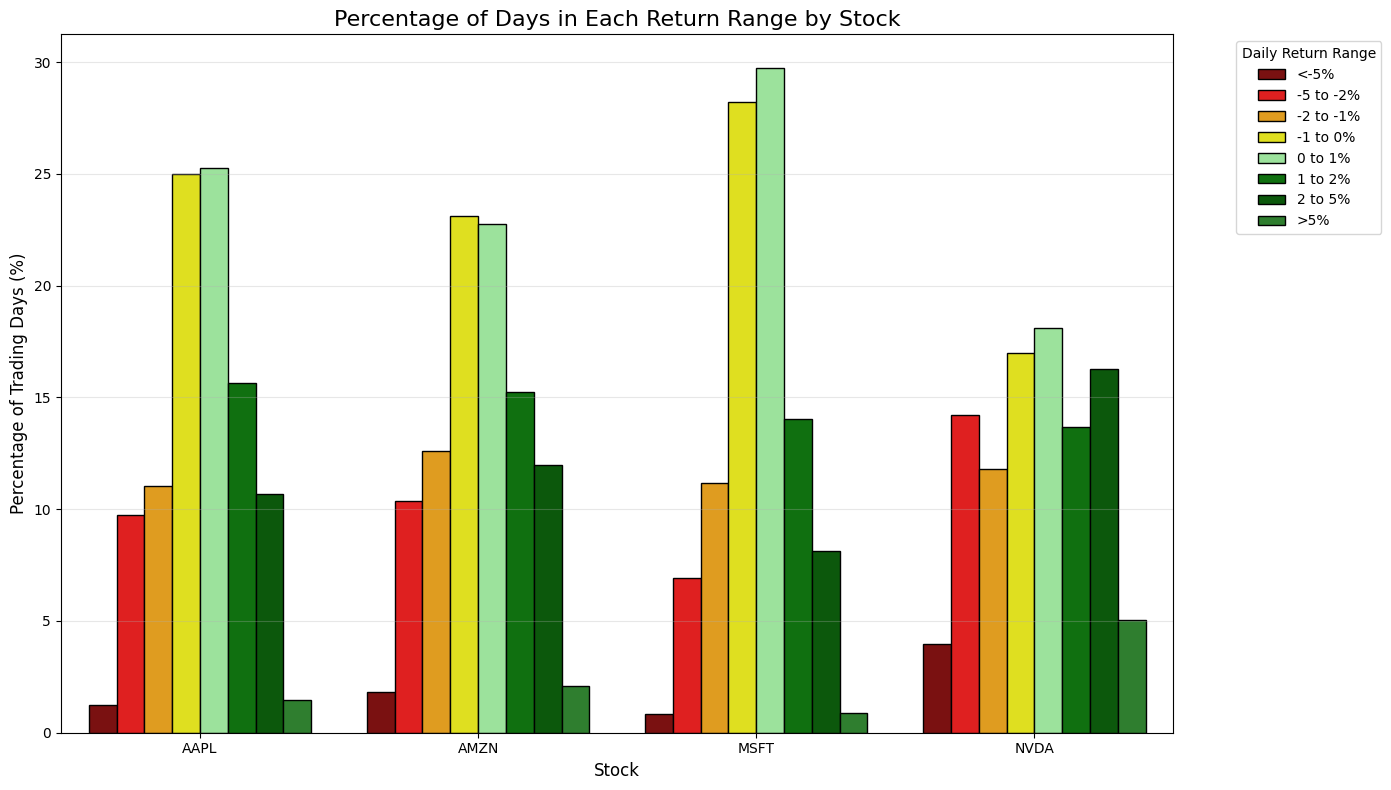

In [10]:
# Simple Daily Return Distribution Analysis
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np


# Define return ranges from worst to best
return_categories = ['<-5%', '-5 to -2%', '-2 to -1%', '-1 to 0%', '0 to 1%', '1 to 2%', '2 to 5%', '>5%']

# The actual number ranges for each category
bucket_ranges = [-100, -5, -2, -1, 0, 1, 2, 5, 100]  # Using -100 and 100 as extremes


stocks_to_analyze = combined_df['Stock'].unique()



all_results = []

for stock_name in stocks_to_analyze:

    # Get daily returns for this stock
    stock_data = combined_df[combined_df['Stock'] == stock_name]
    daily_returns = stock_data['Daily_Return'].dropna()
    total_days = len(daily_returns)


    # Count how many days fall into each return category
    for i, category in enumerate(return_categories):
        min_return = bucket_ranges[i]
        max_return = bucket_ranges[i + 1]

        # Count days in this range
        if i == 0:  # First category: less than -5%
            days_in_range = len(daily_returns[daily_returns < -5])
        elif i == len(return_categories) - 1:  # Last category: greater than 5%
            days_in_range = len(daily_returns[daily_returns >= 5])
        else:  # Middle categories: between two values
            days_in_range = len(daily_returns[(daily_returns >= min_return) & (daily_returns < max_return)])

        # Calculate percentage
        percentage = (days_in_range / total_days) * 100

        # Store the result
        all_results.append({
            'Stock': stock_name,
            'Return_Category': category,
            'Days_in_Range': days_in_range,
            'Percentage': percentage
        })

# table
results_df = pd.DataFrame(all_results)
display(results_df.head(10))

# graph
plt.figure(figsize=(14, 8))

# Get unique stocks for x-axis positioning
unique_stocks = results_df['Stock'].unique()
x_positions = range(len(unique_stocks))

# Set up colors (green spectrum from red to green)
colors = ['darkred', 'red', 'orange', 'yellow', 'lightgreen', 'green', 'darkgreen', 'forestgreen']

sns.barplot(data=results_df, x='Stock', y='Percentage', hue='Return_Category',
            palette=colors, edgecolor='black')

# Format the chart
plt.title('Percentage of Days in Each Return Range by Stock', fontsize=16)
plt.xlabel('Stock', fontsize=12)
plt.ylabel('Percentage of Trading Days (%)', fontsize=12)
plt.legend(title='Daily Return Range', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.grid(axis='y', alpha=0.3)
plt.tight_layout()
plt.show()


**Interpretation**

Most stocks show similar moderate behavior with relatively balanced distributions, with the majority of trading days falling in the small positive ranges, indicating steady but small daily gains. Overall even with magnitute of returns it shows that positive returns are in general higher than negative returns. This can be useful for long term investors since over the years this shows that the gains are more than losses.

**Code Description:**
The code creates two complementary visualizations using seaborn: a violin plot (left) showing the full distribution shape of daily returns across different volatility levels, and a box plot (right) summarizing daily volatility statistics across return categories.


Violin plots: Show full distribution shapes of returns across volatility levels, revealing skewness and outliers

Box plots: Show volatility distributions with quartiles, highlighting median and outliers

Although both are similar both are included to provide good interpretations of the data.

In [11]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np

plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
sns.violinplot(data=combined_df, x='Volatility_Level', y='Daily_Return', hue='Volatility_Level', legend=False)
plt.title('Return Distribution by Volatility Level')
plt.ylabel('Daily Return (%)')

plt.subplot(1, 2, 2)
sns.boxplot(data=combined_df, x='Return_Category', y='Daily_Volatility', hue='Return_Category', legend=False)
plt.title('Volatility Distribution by Return Category')
plt.ylabel('Daily Volatility (%)')
plt.xticks(rotation=45)

plt.tight_layout()
plt.show()


**Interpretation:**

**Left Plot - Return Distribution by Volatility Level:**
- **Low volatility days** show a narrow, concentrated distribution of returns
- **Medium volatility days** display a wider distribution with returns
- **High volatility days** exhibit the broadest distribution with extreme returns reaching -30% to +30%, demonstrating that high volatility periods can produce both large gains and losses
- All distributions are roughly centered around 0%, but the "width" increases drastically with volatility level

**Right Plot - Volatility Distribution by Return Category:**
- **Negative return days** show median volatility around 3-4%, with many outliers extending to 15%+, suggesting bad news often comes with increased market uncertainty
- **Neutral return days** display the lowest median volatility (~2%), indicating quiet, stable trading periods
- **Positive return days** show slightly higher median volatility than neutral days (~3%), with numerous outliers reaching 15-30%

 These show thata there's a relationship between volatility and return magnitude - higher volatility enables both bigger gains and bigger losses, while low volatility constrains returns to smaller ranges. Negative days tend to be more volatile than positive days, reflecting the common market phenomenon that "stocks take the stairs up and the elevator down."

**Code Description:**

This cell computes a Pearson correlation matrix for numeric variables and visualizes it with a masked upper triangle so each pair appears once.
A diverging palette centered at zero highlights direction and strength, with annotations for readable values.
The printed summary lists correlations above a small threshold to focus attention on relationships that are more likely to matter.

Heatmap is good for correlation matrix visualization, using color intensity to represent relationship strength

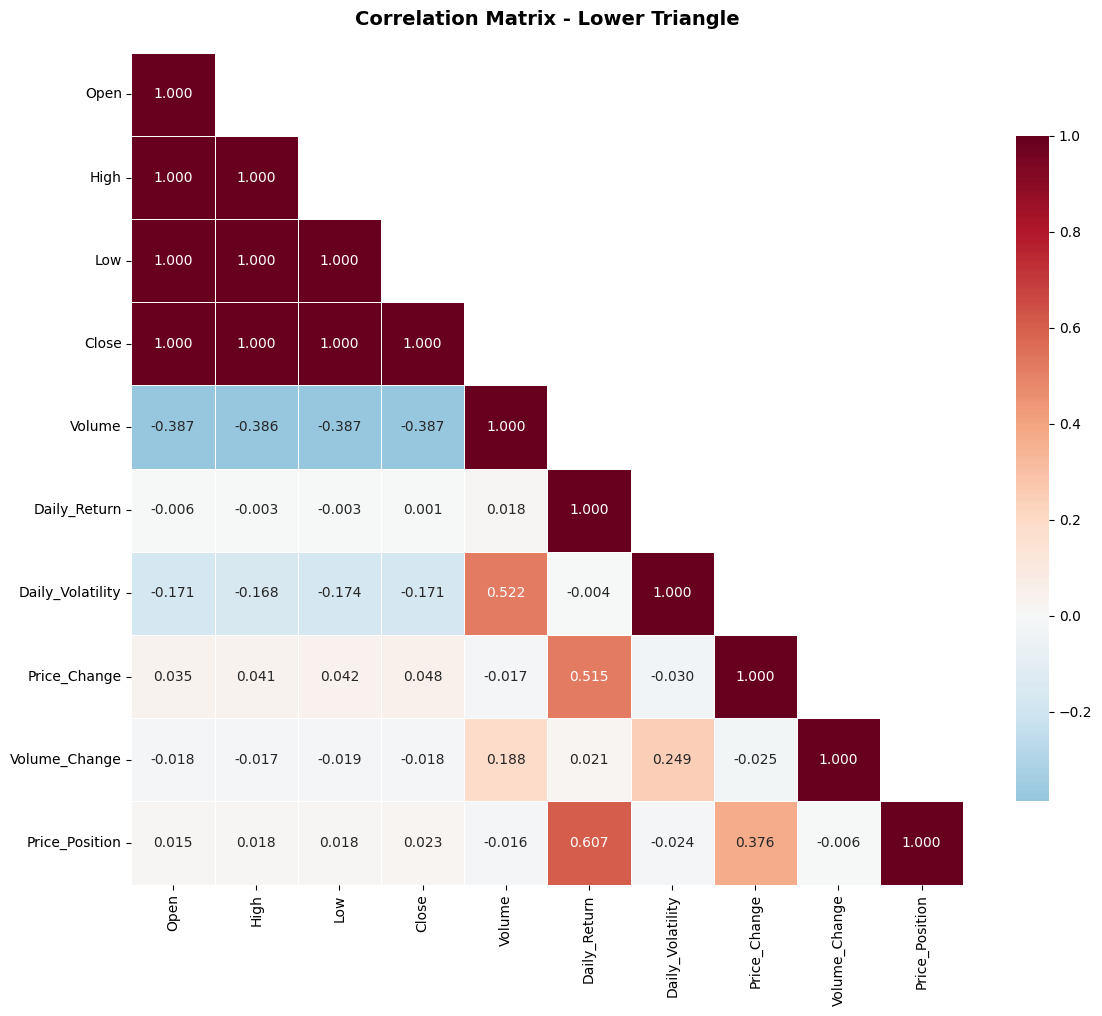

In [12]:
# Comprehensive Correlation Analysis
numerical_cols = ['Open', 'High', 'Low', 'Close', 'Volume', 'Daily_Return',
                  'Daily_Volatility', 'Price_Change', 'Volume_Change', 'Price_Position']
corr = combined_df[numerical_cols].corr()

# Create enhanced heatmap
plt.figure(figsize=(12, 10))
mask = np.triu(np.ones_like(corr, dtype=bool), k=1)
sns.heatmap(corr, mask=mask, annot=True, cmap='RdBu_r', center=0,
            fmt='.3f', square=True, linewidths=0.5, cbar_kws={"shrink": 0.8})
plt.title('Correlation Matrix - Lower Triangle', fontsize=14, fontweight='bold', pad=20)
plt.tight_layout()
plt.show()


**Interpretation:**

Strong Price Relationships (0.999+ correlations):

Open, High, Low, and Close prices move almost perfectly together
Indicates that there is no huge changes happening in stock prices within a single day.

Moderate negative correlation (around -0.39) between stock prices during the day (Open, High, Low, and Close) and Volume. This can indicate that the price of the stock on the particular day influences how much volume is being traded. If the price is lower there are more trades and vice versa.

Very weak correlation (-0.0055) between Daily Returns and Volatility:

No clear daily risk-reward relationship

Although we have another interpretation from the violin plot and box plot earlier this can prove that returns aren't predictable from volatility alone. But at the same time correltion may not work well between return and volatility since volatility can cause return to increase or decrease so there is no linear relatonship here. (High volatility produces both large gains and losses, making volatility alone insufficient for predicting returns.)

**Code Description:**

This code creates a Pearson correlation matrix to measure how similarly the 4 tech stocks (AAPL, AMZN, MSFT, NVDA) move together over time. It reshapes the stock data so each stock becomes a separate column, calculates correlations between their closing prices, and displays the results in a color-coded heatmap.

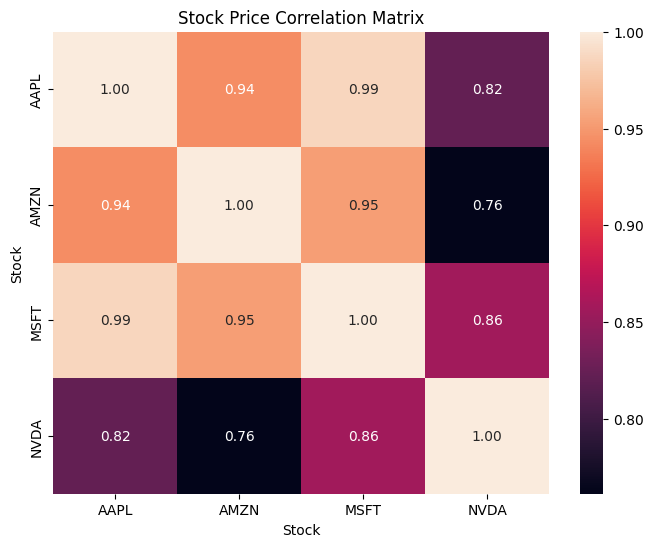

Stock  AAPL  AMZN  MSFT  NVDA
Stock                        
AAPL   1.00  0.94  0.99  0.82
AMZN   0.94  1.00  0.95  0.76
MSFT   0.99  0.95  1.00  0.86
NVDA   0.82  0.76  0.86  1.00


In [13]:
# Simple Stock Correlation Matrix using Pearson


# Step 1: Reshape data so each stock is a column
stock_pivot = combined_df.pivot(index='Date', columns='Stock', values='Close')

# Step 2: Calculate Pearson correlation between stocks
correlation_matrix = stock_pivot.corr(method='pearson')

# Step 3: Create simple heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(correlation_matrix,
            annot=True,      # Show numbers *
            fmt='.2f')       # 2 decimal places

plt.title('Stock Price Correlation Matrix')
plt.show()

# Step 4: Print the numbers
print(correlation_matrix.round(2))

**Strongest Relationships:**
- **AAPL and MSFT** have a high correlation, meaning they move almost identically - possibly since they're both tech giants with similar market.
- **AMZN and MSFT** also show very strong correlation.

- **NVDA has low correlations** with traditional tech stocks, suggesting it may follow somewhat different market patterns

**Overall Pattern:**
All correlations are quite high, showing that these tech stocks generally move as a group during market ups and downs, but NVDA's unique position possibly due to semiconductor industry makes it a bit unique.

This code identifies the best and worst 365-day performance periods for each stock by calculating forward-looking annual returns and finding the maximum growth and steepest decline periods.
For every single day in the dataset, the code calculates a potential 365-day return starting from that day.

It then creates a comparison bar chart showing the percentage gains/losses for these extreme periods across all stocks, with green bars for growth and red bars for falls.

In [14]:
# Sort data so dates go from oldest to newest for each stock
df = combined_df.sort_values(['Stock', 'Date']).copy()
df = df.reset_index(drop=True)

# Calculate all possible 365-day returns
# For every row, calculate what would happen if you bought and held for 365 days
all_returns = []

for i in range(len(df)):
    current_row = df.iloc[i]
    stock_name = current_row['Stock']
    start_date = current_row['Date']
    start_price = current_row['Close']

    # Look for the same stock 364 positions later (which is 365 days total)
    end_position = i + 364

    # Check if we have data 365 days later for the same stock
    if end_position < len(df):
        future_row = df.iloc[end_position]

        # Make sure it's the same stock and prices are valid
        if (future_row['Stock'] == stock_name and
            start_price > 0 and
            future_row['Close'] > 0):

            end_date = future_row['Date']
            end_price = future_row['Close']

            # Calculate the return percentage
            return_percent = ((end_price / start_price) - 1) * 100

            # Store all the details
            all_returns.append({
                'Stock': stock_name,
                'Start_Date': start_date,
                'End_Date': end_date,
                'Start_Price': start_price,
                'End_Price': end_price,
                'Return_Percent': return_percent
            })

# Convert to DataFrame
returns_df = pd.DataFrame(all_returns)

final_results = []

# Go through each stock one by one
for stock_name in df['Stock'].unique():

    # Get all 365-day periods for this stock
    stock_returns = returns_df[returns_df['Stock'] == stock_name]

    if len(stock_returns) > 0:
        # Find the row with highest return (best growth)
        best_growth_idx = stock_returns['Return_Percent'].idxmax()
        best_growth = stock_returns.loc[best_growth_idx]

        # Add to final results
        final_results.append({
            'Stock': stock_name,
            'Type': 'Best Growth',
            'Start_Date': best_growth['Start_Date'],
            'End_Date': best_growth['End_Date'],
            'Start_Price': best_growth['Start_Price'],
            'End_Price': best_growth['End_Price'],
            'Return_Percent': best_growth['Return_Percent']
        })

        # Find the row with lowest return (worst fall)
        worst_fall_idx = stock_returns['Return_Percent'].idxmin()
        worst_fall = stock_returns.loc[worst_fall_idx]

        # Add to final results
        final_results.append({
            'Stock': stock_name,
            'Type': 'Worst Fall',
            'Start_Date': worst_fall['Start_Date'],
            'End_Date': worst_fall['End_Date'],
            'Start_Price': worst_fall['Start_Price'],
            'End_Price': worst_fall['End_Price'],
            'Return_Percent': worst_fall['Return_Percent']
        })

# results table
results_table = pd.DataFrame(final_results)
display(results_table)

# Separate growth and fall data
growth_data = results_table[results_table['Type'] == 'Best Growth'].copy()
fall_data = results_table[results_table['Type'] == 'Worst Fall'].copy()

# bar graph
plt.figure(figsize=(12, 7))

# Get stock names and their positions for x-axis
stock_names = growth_data['Stock'].tolist()
x_positions = list(range(len(stock_names)))

# Create bars side by side
bar_width = 0.35
growth_positions = [x - bar_width/2 for x in x_positions]
fall_positions = [x + bar_width/2 for x in x_positions]

# Plot the bars
growth_bars = plt.bar(growth_positions, growth_data['Return_Percent'],
                     bar_width, label='Best Growth', color='green', edgecolor='black')
fall_bars = plt.bar(fall_positions, fall_data['Return_Percent'],
                   bar_width, label='Worst Fall', color='red', edgecolor='black')

# Add horizontal line at 0%
plt.axhline(0, color='gray', linewidth=1, alpha=0.7)

# Labels and title
plt.title('365-Day Maximum Growth vs Steepest Fall', fontsize=14)
plt.ylabel('Return (%)')
plt.xlabel('Stock')
plt.xticks(x_positions, stock_names)
plt.legend()
plt.tight_layout()
plt.show()

Stock         Type Start_Date   End_Date  Start_Price   End_Price  \
0  AAPL  Best Growth 2006-07-14 2007-12-24     1.521120    5.968000   
1  AAPL   Worst Fall 2007-09-26 2009-03-09     4.586172    2.494971   
2  AMZN  Best Growth 2008-11-20 2010-05-05     1.751500    6.546500   
3  AMZN   Worst Fall 2021-07-12 2022-12-19   185.927505   84.919998   
4  MSFT  Best Growth 2020-03-16 2021-08-24   129.171234  292.822296   
5  MSFT   Worst Fall 2007-11-01 2009-04-15    26.533306   13.870062   
6  NVDA  Best Growth 2023-01-05 2024-06-18    14.251528  135.529541   
7  NVDA   Worst Fall 2007-09-12 2009-02-23     0.761473    0.166415   

   Return_Percent  
0      292.342554  
1      -45.597952  
2      273.765354  
3      -54.326285  
4      126.693116  
5      -47.725844  
6      850.982541  
7      -78.145703

The table lists, for each stock, the single best 365‑day growth window and the single worst 365‑day fall window, with start/end dates, start/end prices, and the simple percent return over that year.
“Growth” marks the top one‑year gain from a given start date, and “Fall” marks the steepest one‑year loss from a given start date; returns are based on Close prices.

The same information can also be interpreted in a visual way from the bar graph above.

**Key Interpretation**

NVDA has a high +851% one‑year increase in 2023–2024, but it also shows the largest drop of 78% in 2007–2009.


**Limitations**

* Dataset only includes successful large-cap tech stocks, not representative of broader market
* These companies survived and thrived, excluding failed companies from analysis
* Only top 5 stocks analyzed, may not represent sector-wide patterns
* Analysis excludes companies that may have failed or been delisted
* Limitation: Past performance does not guarantee future results since there is volatility even long term as seen in line graph that shows stock prices over time.
* No consideration of market events, earnings, or economic indicators that drive price movements
* Patterns observed may be specific to the analysis period and world events and not generalizable

EDA revealed strong correlations between daily price metrics (Open/High/Low/Close) but weak correlation among other parameters as can be seen from coorelation heatmap
Distribution analysis showed all stocks have more positive than negative trading days, supporting long-term growth
Demonstrated that extreme returns (both positive and negative) occur during high volatility periods
Analysis identified specific periods of exceptional growth and significant falls

Note: META stock was removed for project 2 and the above codes since its IPO was at a later date: May 18, 2012 which resulted in model training issues. Now the analysis is based on top 4 stocks in the SNP500: NVIDIA, Microsoft, Amazon, Apple

## Question to address in Project:

## Can we predict the direction of 30-day stock price movements (Up >+5%, Same ±5%, Down <-5%) past data?

Prediction of future prices is one of the most valuable information for an investor and a trader which is why this research question was chosen.

Although there are many factors that determine the stock prices such as company performance, economy, world events (sentiment analysis), this project specifically considers only the past data and trends to predict future performance.

This was also chosen to analyse based on the feedback for prpoject 1 to further strengthen the project: "more explicitly to practical implications for investors or market interpretation, rather than leaving them at a surface level."

This code cell prepares the dataset by creating three key features (30-day momentum, price range, and volume change) to predict future 30-day price direction.

Data is split at 2021-09-19, using (19-09-2005 to 2021-09-19) data for training and the rest of the data until 19-09-2025 for testing. By data split approach, setting the date split at 221-09-19 ensured that the data used for training was 80% and 20% for testing.

A simple random split without a specific date that splits training and testing data (e.g., 70% for training, 30% for testing out of the entire data) was not suitable here. Models trained with this kind of split resulted in extremely good performance showing that there was data leakage where the model has access to the prices of the period it is supposed to predict. This kind of split also does not work in the real world scenario since it is only possible to predict future prices with data until the current date.

Target Variable:
The target classifies future 30-day returns into three categories using ±5% thresholds:

'Down': Return < -5% (significant decline)
'Same': Return between -5% and +5% (sideways movement)
'Up': Return > +5% (significant gain)

This ±5% threshold filters out minor price fluctuations and focuses predictions on meaningful market movements.

The target labels each example as 'Up', 'Down', or 'Same' based on the 30-day future return and all feature values are standardized using a scaler so the model can learn effectively from each feature.

In [15]:


# Prepare data
df = combined_df.copy().sort_values(['Stock', 'Date']).reset_index(drop=True)

# Features
df['Momentum_30'] = df.groupby('Stock')['Close'].pct_change(periods=30).shift(1)
df['Price_Range'] = ((df['High'] - df['Low']) / df['Close']).shift(1)
df['Volume_Change'] = df.groupby('Stock')['Volume'].pct_change(periods=30).shift(1)

# Target: 30-day future return
df['Future_Return_30'] = df.groupby('Stock')['Close'].pct_change(periods=30).shift(-30)
df['Target'] = pd.cut(df['Future_Return_30'],
                      bins=[-np.inf, -0.05, 0.05, np.inf],
                      labels=['Down', 'Same', 'Up'])

# Clean data
features = ['Momentum_30', 'Price_Range', 'Volume_Change', 'Open', 'High', 'Low', 'Close']
df_clean = df[features + ['Target', 'Date']].dropna()

X = df_clean[features]
y = df_clean['Target']

# Train/test split
split_date = '2021-09-19'
train_mask = df_clean['Date'] < split_date
test_mask = df_clean['Date'] >= split_date

X_train, X_test = X[train_mask], X[test_mask]
y_train, y_test = y[train_mask], y[test_mask]

# Scale
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

print(f"Data prepared: {len(X_train)} training samples, {len(X_test)} test samples")


Data prepared: 15983 training samples, 3900 test samples


### Model Selection Justification

**Random Forest:** Handles non-linear stock relationships, provides feature importance that could be useful for further analysis

**Decision Tree:** Simpler model to test if complexity is needed and to test its performance

**Logistic Regression:** Tests for linear patterns of different features to predict the direction (whether price is going up/down/sideways)

**SVM (Support Vector Machine):** SVMs can capture non-linear relationships through kernel transformations.

Comparing all four models determines if this problem needs complex modeling (RF/SVM), benefits from interpretable simplicity (DT), or follows linear patterns (LR).

This code compares the performance of four classification models for predicting 30-day stock trends. It calculates key evaluation metrics (accuracy, precision, recall, F1 score) for each model and displays them in a table. Confusion matrices for each model are visualized to show how well each model predicts the three classes ('Down', 'Same', 'Up'). Finally, the code reports which features were most important for the tree-based models, indicating which variables most strongly influenced their predictions.

In [16]:
# Training different models
svm_model = SVC(kernel='rbf', random_state=42)
svm_model.fit(X_train_scaled, y_train)
svm_pred = svm_model.predict(X_test_scaled)

rf_model = RandomForestClassifier(n_estimators=50, max_depth=8, random_state=42)
rf_model.fit(X_train_scaled, y_train)
rf_pred = rf_model.predict(X_test_scaled)

dt_model = DecisionTreeClassifier(max_depth=5, random_state=42)
dt_model.fit(X_train_scaled, y_train)
dt_pred = dt_model.predict(X_test_scaled)

lr_model = LogisticRegression(max_iter=500, random_state=42)
lr_model.fit(X_train_scaled, y_train)
lr_pred = lr_model.predict(X_test_scaled)


In [17]:
# Model comparison
model_names = ['Random Forest', 'Decision Tree', 'Logistic Regression', 'SVM']
predictions = [rf_pred, dt_pred, lr_pred, svm_pred]

# Metrics table
metrics_data = []
for name, pred in zip(model_names, predictions):
    acc = accuracy_score(y_test, pred)
    prec, rec, f1, _ = precision_recall_fscore_support(y_test, pred, average='weighted', zero_division=0)
    metrics_data.append({'Model': name, 'Accuracy': acc, 'Precision': prec, 'Recall': rec, 'F1': f1})

metrics_df = pd.DataFrame(metrics_data)
print("Model Performance Comparison:")
print(metrics_df.to_string(index=False))
print("="*70)

# Confusion matrices
fig, axes = plt.subplots(1, 4, figsize=(20, 4))
for idx, (name, pred) in enumerate(zip(model_names, predictions)):
    cm = confusion_matrix(y_test, pred, labels=['Down', 'Same', 'Up'])
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', ax=axes[idx],
                xticklabels=['Down', 'Same', 'Up'], yticklabels=['Down', 'Same', 'Up'])
    axes[idx].set_title(f'{name}', fontsize=11, fontweight='bold')
    axes[idx].set_ylabel('Actual')
    axes[idx].set_xlabel('Predicted')

plt.tight_layout()
plt.show()

# Feature importance (only for tree-based models)
print("\n" + "="*70)
print("FEATURE IMPORTANCE")
print("="*70)

print("\nRandom Forest:")
feature_imp_rf = pd.DataFrame({
    'Feature': features,
    'Importance': rf_model.feature_importances_
}).sort_values('Importance', ascending=False)
print(feature_imp_rf.to_string(index=False))

print("\nDecision Tree:")
feature_imp_dt = pd.DataFrame({
    'Feature': features,
    'Importance': dt_model.feature_importances_
}).sort_values('Importance', ascending=False)
print(feature_imp_dt.to_string(index=False))

Model Performance Comparison:
              Model  Accuracy  Precision   Recall       F1
      Random Forest  0.382564   0.415944 0.382564 0.342072
      Decision Tree  0.392821   0.356361 0.392821 0.354745
Logistic Regression  0.431795   0.345898 0.431795 0.366313
                SVM  0.408974   0.402131 0.408974 0.356468



FEATURE IMPORTANCE

Random Forest:
      Feature  Importance
          Low    0.183494
        Close    0.181446
         High    0.180579
  Momentum_30    0.163962
         Open    0.147272
  Price_Range    0.083766
Volume_Change    0.059481

Decision Tree:
      Feature  Importance
          Low    0.399924
  Momentum_30    0.215556
        Close    0.179807
         High    0.134268
         Open    0.038294
  Price_Range    0.032151
Volume_Change    0.000000


## Confusion Matrix Interpretation

All four models show similar patterns: they over-predict "Same" and rarely predict "Down" correctly. Logistic Regression makes zero "Down" predictions entirely, while other predict "Down" very little numbre of times.


## Feature Importance Interpretation

**Close/Open/High/Low prices dominate feature importance**, but these capture absolute price levels rather than price dynamics raising questions on whether the model actually predicts based on trends and price patterns. These features primarily show which stock is being predicted (from the price range) rather than capturing directional price dynamics

 Momentum30's moderate importance (0.16) shows the expected positive relationship with Up predictions, where higher 30-day momentum increases the likelihood of continued upward movement. However, the low importance of VolumeChange (0.06) indicates that trading volume shifts provide minimal predictive signal for future price direction. Critically, the models fail to learn proper directional relationships - they cannot distinguish between bullish momentum (high Momentum30 → Up predictions) and bearish signals (negative momentum → Down predictions), instead defaulting to majority class predictions regardless of feature magnitudes.

**Momentum_30** ranks top 3 in both models, suggesting past returns have some predictive potential, but it's not dominating.

**Volume_Change** ranks lowest, indicating trading volume changes provide minimal predictive value for 30-day price direction.

The Decision Tree's heavy reliance on Low alone (0.4) versus Random Forest's more balanced distribution explains why Random Forest performs slightly better.

In conclusion, the models fail to learn proper directional relationships - they cannot distinguish between bullish momentum relationships such as: (high Momentum30 → Up predictions) and bearish signals (negative momentum → Down predictions), instead defaulting to majority class predictions regardless of feature magnitudes. There is also a question on whether the momentum defined here is the correct momentum used by professionals. Here momentum is just calculated as  30-day percentage change in closing prices with a 1-day lag to prevent lookahead bias.

This code performs hyperparameter optimisation to look for improvement in performance in top 2 well performing models.

In [18]:

from sklearn.model_selection import GridSearchCV

lr_params = {
    'C': [0.1, 1, 10],
    'penalty': ['l2'],
    'solver': ['lbfgs'],
}
lr_grid = GridSearchCV(LogisticRegression(max_iter=500, random_state=42),
                       lr_params, cv=3, n_jobs=-1)
lr_grid.fit(X_train_scaled, y_train)
lr_optimized = lr_grid.best_estimator_
lr_opt_pred = lr_optimized.predict(X_test_scaled)

print("LR Best Params:", lr_grid.best_params_)
print("LR Optimized Accuracy:", accuracy_score(y_test, lr_opt_pred))
print("LR Original Accuracy:", accuracy_score(y_test, lr_pred))

# SVM - fast grid
svm_params = {
    'C': [0.1, 1, 10],
    'kernel': ['rbf'],
    'gamma': ['scale', 'auto']
}
svm_grid = GridSearchCV(SVC(random_state=42), svm_params, cv=3, n_jobs=-1)
svm_grid.fit(X_train_scaled, y_train)
svm_optimized = svm_grid.best_estimator_
svm_opt_pred = svm_optimized.predict(X_test_scaled)

print("\nSVM Best Params:", svm_grid.best_params_)
print("SVM Optimized Accuracy:", accuracy_score(y_test, svm_opt_pred))
print("SVM Original Accuracy:", accuracy_score(y_test, svm_pred))

LR Best Params: {'C': 0.1, 'penalty': 'l2', 'solver': 'lbfgs'}
LR Optimized Accuracy: 0.43205128205128207
LR Original Accuracy: 0.4317948717948718

SVM Best Params: {'C': 0.1, 'gamma': 'scale', 'kernel': 'rbf'}
SVM Optimized Accuracy: 0.41384615384615386
SVM Original Accuracy: 0.40897435897435896


## Hyperparameter Optimization Analysis

This code cell below performs GridSearchCV on Logistic Regression and SVM to find optimal hyperparameters. It then analyzes the optimized models by:

1. **Actual Returns Analysis:** For each prediction class (Up/Down/Same), calculates what actually happened - mean/median returns, standard deviation, and directional accuracy
2. **Overall Confusion Matrices:** Shows prediction patterns across all test data for both optimized models
3. **Per-Stock Breakdown:** Creates individual confusion matrices for each of the 4 stocks (AAPL, AMZN, MSFT, NVDA) to identify if certain stocks are more/less predictable

This helps us see which specific stocks and classes each model forecasts well or poorly and making better investment decisions based on model outputs.


OPTIMIZED MODELS - ACTUAL RETURNS ANALYSIS

LR OPTIMIZED

When predicts 'Down': No predictions made

When predicts 'Same':
  Count: 2590 predictions
  Mean actual return: 1.90%
  Median actual return: 1.98%
  Std dev: 9.40%
  Range: [-37.77%, 47.04%]
  Directionally correct: 1037/2590 (40.0%)

When predicts 'Up':
  Count: 1310 predictions
  Mean actual return: 6.91%
  Median actual return: 4.74%
  Std dev: 19.10%
  Range: [-41.97%, 59.02%]
  Directionally correct: 648/1310 (49.5%)

SVM OPTIMIZED

When predicts 'Down': No predictions made

When predicts 'Same':
  Count: 1942 predictions
  Mean actual return: 1.96%
  Median actual return: 2.08%
  Std dev: 10.77%
  Range: [-37.77%, 51.03%]
  Directionally correct: 737/1942 (38.0%)

When predicts 'Up':
  Count: 1958 predictions
  Mean actual return: 5.19%
  Median actual return: 3.26%
  Std dev: 15.87%
  Range: [-41.97%, 59.02%]
  Directionally correct: 877/1958 (44.8%)

OVERALL CONFUSION MATRICES


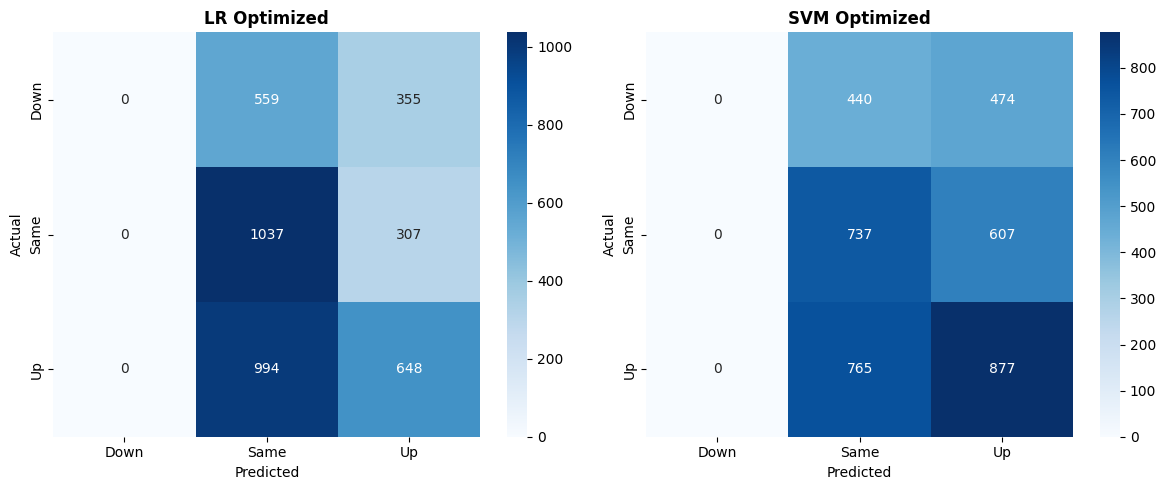


PER-STOCK CONFUSION MATRICES

LR OPTIMIZED


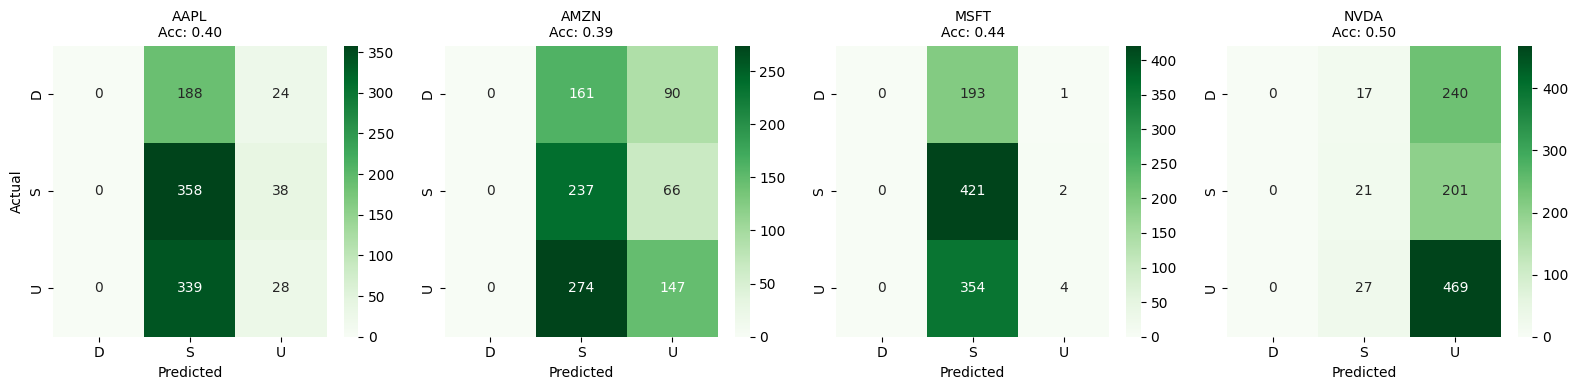


LR Optimized - Stock Accuracy Summary:
Stock   N Accuracy
 AAPL 975    0.396
 AMZN 975    0.394
 MSFT 975    0.436
 NVDA 975    0.503

SVM OPTIMIZED



SVM Optimized - Stock Accuracy Summary:
Stock   N Accuracy
 AAPL 975    0.424
 AMZN 975    0.428
 MSFT 975    0.310
 NVDA 975    0.494


In [19]:
# Optimized models analysis - LR and SVM only
opt_model_names = ['LR Optimized', 'SVM Optimized']
opt_predictions = [lr_opt_pred, svm_opt_pred]

test_indices = df_clean[test_mask].index
test_data_base = df.loc[test_indices].copy()

print("\n" + "="*70)
print("OPTIMIZED MODELS - ACTUAL RETURNS ANALYSIS")
print("="*70)

for model_name, pred in zip(opt_model_names, opt_predictions):
    print(f"\n{'='*70}")
    print(f"{model_name.upper()}")
    print(f"{'='*70}")

    test_data_analysis = test_data_base.copy()
    test_data_analysis['Predicted'] = pred
    test_data_analysis['Actual_Return'] = test_data_analysis['Future_Return_30']

    for pred_class in ['Down', 'Same', 'Up']:
        subset = test_data_analysis[test_data_analysis['Predicted'] == pred_class]['Actual_Return']
        if len(subset) > 0:
            print(f"\nWhen predicts '{pred_class}':")
            print(f"  Count: {len(subset)} predictions")
            print(f"  Mean actual return: {subset.mean()*100:.2f}%")
            print(f"  Median actual return: {subset.median()*100:.2f}%")
            print(f"  Std dev: {subset.std()*100:.2f}%")
            print(f"  Range: [{subset.min()*100:.2f}%, {subset.max()*100:.2f}%]")

            if pred_class == 'Up':
                correct = (subset > 0.05).sum()
            elif pred_class == 'Down':
                correct = (subset < -0.05).sum()
            else:
                correct = ((subset >= -0.05) & (subset <= 0.05)).sum()

            print(f"  Directionally correct: {correct}/{len(subset)} ({correct/len(subset)*100:.1f}%)")
        else:
            print(f"\nWhen predicts '{pred_class}': No predictions made")

# Overall confusion matrices
print("\n" + "="*70)
print("OVERALL CONFUSION MATRICES")
print("="*70)

fig, axes = plt.subplots(1, 2, figsize=(12, 5))
for idx, (name, pred) in enumerate(zip(opt_model_names, opt_predictions)):
    cm = confusion_matrix(y_test, pred, labels=['Down', 'Same', 'Up'])
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', ax=axes[idx],
                xticklabels=['Down', 'Same', 'Up'], yticklabels=['Down', 'Same', 'Up'])
    axes[idx].set_title(f'{name}', fontsize=12, fontweight='bold')
    axes[idx].set_ylabel('Actual')
    axes[idx].set_xlabel('Predicted')
plt.tight_layout()
plt.show()

# Per-stock confusion matrices
print("\n" + "="*70)
print("PER-STOCK CONFUSION MATRICES")
print("="*70)

# Get unique stocks from the data
stocks = sorted(test_data_base['Stock'].unique())

for model_name, pred in zip(opt_model_names, opt_predictions):
    print(f"\n{model_name.upper()}")

    test_data_stocks = test_data_base.copy()
    test_data_stocks['Predicted'] = pred

    fig, axes = plt.subplots(1, 4, figsize=(16, 4))

    for idx, stock in enumerate(stocks):
        stock_data = test_data_stocks[test_data_stocks['Stock'] == stock]

        if len(stock_data) > 0:
            y_stock_true = stock_data['Target']
            y_stock_pred = stock_data['Predicted']

            cm = confusion_matrix(y_stock_true, y_stock_pred, labels=['Down', 'Same', 'Up'])
            sns.heatmap(cm, annot=True, fmt='d', cmap='Greens', ax=axes[idx],
                       xticklabels=['D', 'S', 'U'], yticklabels=['D', 'S', 'U'])

            acc = accuracy_score(y_stock_true, y_stock_pred)
            axes[idx].set_title(f'{stock}\nAcc: {acc:.2f}', fontsize=10)
            axes[idx].set_ylabel('Actual' if idx == 0 else '')
            axes[idx].set_xlabel('Predicted')
        else:
            axes[idx].text(0.5, 0.5, 'No data', ha='center', va='center')
            axes[idx].set_title(f'{stock}')

    plt.tight_layout()
    plt.show()

    # Print stock-wise accuracy summary
    print(f"\n{model_name} - Stock Accuracy Summary:")
    stock_summary = []
    for stock in stocks:
        stock_data = test_data_stocks[test_data_stocks['Stock'] == stock]
        if len(stock_data) > 0:
            acc = accuracy_score(stock_data['Target'], stock_data['Predicted'])
            stock_summary.append({'Stock': stock, 'N': len(stock_data), 'Accuracy': f"{acc:.3f}"})

    print(pd.DataFrame(stock_summary).to_string(index=False))

**Problems in Predictions:**
- **Both models** makes zero "Down" predictions after optimisation which is very surprising, completely ignoring potential losses.

This could also be due to the fact that stocks that makes downward trend recovered in the training data since these are few of the best stocks in the world and percentage of bear market is low as discussed later.


**Up**
- Both models show slightly better directional accuracy for "Up" and "Same"
- Mean returns when predicting "Up": 6.91% (LR) and 5.19% (SVM) - this shows a good sign about the models that whenever it predicts up the mean is returns is higher than when it predicted down or same.
- BUT: High standard deviations (upto 19%) shows extreme volatility and possibilities of losing money.

**Stock-Specific Performance Varies Dramatically:**
- **NVDA** shows best predictability (49,50% accuracy with the 2 models)
- **MSFT** shows worst with SVM (31% accuracy) - worse than random guessing
- Most stocks hover slightly better than random guessing probability.

Hyperparameter tuning didn't solve the fundamental problem and there was a very slight improvevment in accuracy. Models here still can't reliably predict direction because historical price/volume features miss the real influence (news, earnings, macro events).

## Model Performance Evaluation

### Metrics and Interpretation

 The 39-53% accuracy (across 2 models and 5 stocks) is weak for a 3-class problem but still better than random guessing. Potential problem to consider is: Confusion matrices show that models achieve this accuracy by defaulting to the majority class rather than learning discriminative patterns. Returns observed from model predictions also show extreme standard deviations. So the models cannot be used in real life to make trades.

---

## Q1: Insights About Predictive Ability

Refer Feature Importance Interpretation and Confusion Matrix Interpretation 6 cells above.

The models demonstrate inadequate predictive power for practical investment decisions. While accuracy ranges from 39-53%, this represents only a slight improvement over random guessing (33% baseline for 3-class classification).

**Limitations identified:**
1. **Class imbalance** There may not be a huge problem with class imbalance since the model predicts differently for each stock. (LR predicts same most for MSFT and Up most for NVDA).
2. **Risk management failure:** Inability to predict declines (Both optimised makes zero "Down" predictionss) leaves investors exposed to losses

**Potential major cause:** Historical price/volume features miss the actual drivers of stock movements (earnings announcements, macroeconomic shifts, news sentiment, regulatory changes). The weak correlation between time and price (R²=0.125 from later code cells) proves prices don't follow predictable patterns from technical indicators alone.

---

## Q2: Interpretation of Variables


Feature Importance Analysis (Tree-based models) discussed few cells above.

Summary - Tree-based models mostly pick 'up' on which stock is being predicted based on price levels rather than recognizing genuine market signals or patterns.

Logically, higher Momentum_30 values should increase "Up" predictions, while higher Price_Range should  increase "Up/Down" compared to "Same" predictions when we think logically. However, the feature importnace show a problem in the model's learning.

**Hyperparameter tuning results:** Basic GridSearchCV found optimal parameters but accuracy improved minimally, confirming that the problem is not model configuration.

---

## Q3: Generalization to Test Data

Model predictions mirror the class breakdown in training data.

Most predictions are "Up" or “Same,” matching the majority classes as can be seen in later cells with fewer “Down.”

This suggests the models are not overfitting to training patterns but rather learning the underlying class distribution limitations. Hyperparameter tuning resulting in very small improvement indicates stable but limited predictive capability.

**Test period robustness:** The 4-year test window spans multiple market conditions:
- 2022 bear market (inflation)
- 2023 AI boom (NVDA surge)
- 2024-2025 volatility


**Generalization**

Models can't consistently predict prices across stocks. The regime classification analysis (showing distinct Bull/Bear/Sideways periods) in a later code cell proves market conditions shift, but models can't detect these regime changes.


## Q4: Model Performance Evaluated and Generalization Discussed
Performance Metrics Analysis:
The optimized models achieved 39-53% accuracy across four stocks, representing marginal improvement over random baseline (33% for 3-class classification). Despite hyperparameter tuning through GridSearchCV, accuracy improvements were minimal, confirming the limitation stems from quality of features used in training the models rather than model configuration.​

Generalization:
The train-test split (2005-2021 for training, 2021-2025 for testing) demonstrates generalization across diverse market conditions including the 2022 bear market, 2023 AI boom, and 2024-2025 volatility periods. But model predictions consistently mirror training class distributions showing limited learning of potential patterns rather than overfitting.​

Critical Performance Issues:
Both optimized models exhibit bias, making zero "Down" predictions and over-predicting "Same" class, exposing investors to unmitigated risk. High return standard deviations (up to 19%) in spite of accuracy in predicted direction show these models cannot support practical trading decisions.​

## Q5: Feature Contributions and Interpretations Explained
Feature Importance Analysis:
Tree-based models show problematic learning patterns where absolute price levels (Close/Open/High/Low) dominate feature importance rather than price dynamics. These features primarily identify which stock is being predicted based on price ranges (that differ in each stock) rather than capturing genuine directional market signals which are what would be useful to predict the direction of the stock market.

Momentum Relationships:
Momentum_30 shows moderate importance (0.16) with expected directional relationship to "Up" predictions, confirming some usefulness in past price trends. However, VolumeChange demonstrates minimal importance (0.06), indicating trading volume shifts provide negligible predictive value for 30-day price movements.​

Model Learning Deficiencies:
Critical failure in directional pattern recognition - models cannot distinguish between bullish signals (high Momentum_30 → Up predictions possibly) and bearish indicators (negative momentum → Down predictions possibly), defaulting to majority class predictions regardless of feature magnitudes.​

## Q6: Analysis Quality and Limitations Addressed
Methodological Strengths:
Time-series appropriate data splitting prevents data leakage while maintaining chronological integrity that can be applied to real world scenario. Multiple model comparison (Random Forest, Decision Tree, Logistic Regression, SVM) shows performance limitations across different algorithmic approaches proving that there may be no correlation or the features given to the model to predict has to be changed.​

Fundamental Limitations of the model to address the main question (predicting future price):
Historical price/volume features miss actual market drivers including earnings announcements, macroeconomic events, news sentiment, and regulatory changes. Linear correlation analysis reveals weak time-price relationship (R² = 0.125), confirming prices don't follow predictable technical patterns alone.​

Although the stocks appear to move in the same direction together more or less as can be seen from the line graph, this shows that in a sort time there may be fluctuations in individual stocks in the direction and magnitute of price change which could be the reason why one model is not enough to apply to all the stocks to see predictions.

## Conclusion:
Models demonstrate inadequate risk management by failing to predict market declines, potentially exposing portfolios to significant losses during bear market periods. Stock-specific performance variation (NVDA: 49-50% accuracy vs MSFT: 31% with SVM) indicates inconsistent predictive capability across securities.

## Trying to analyse the poor performance of the models with data

The following analysis was made to analyse the data due to the poor performance of the models and to find the reason for it and to try a more appropritae model possibly. But the other models tried did not perform well as well. And these analysis acts as a reson to show that it would not be possible to predict the future prices trend. From DATA602 we learned that we need to analyse residuals and R^2 to check linear relationships. The coefficient of correlation should ideally be close to 1 or -1. Low values of R^2 and non-random residual patterns both show that the linear assumption is not suitable for the data.

In [20]:
from scipy import stats

# Get test data with dates
test_data = df_clean[test_mask].copy()
test_data['Days_Since_Start'] = (test_data['Date'] - test_data['Date'].min()).dt.days

# Linear regression
slope, intercept, r_value, p_value, std_err = stats.linregress(
    test_data['Days_Since_Start'], test_data['Close'])

print(f"Linear Correlation: {test_data[['Days_Since_Start', 'Close']].corr().iloc[0,1]:.3f}")
print(f"Linear R²: {r_value**2:.3f}")
print(f"P-value: {p_value:.4f}")

# Visualization
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))

# Price vs Time
ax1.scatter(test_data['Days_Since_Start'], test_data['Close'], alpha=0.3, s=10)
ax1.plot(test_data['Days_Since_Start'],
         slope * test_data['Days_Since_Start'] + intercept,
         'r--', label=f'Linear Fit (R²={r_value**2:.3f})')
ax1.set_xlabel('Days Since Start')
ax1.set_ylabel('Close Price ($)')
ax1.set_title('Price vs Time (Linear Fit)')
ax1.legend()
ax1.grid(True, alpha=0.3)

# Residuals
predicted_linear = slope * test_data['Days_Since_Start'] + intercept
residuals = test_data['Close'] - predicted_linear
ax2.scatter(predicted_linear, residuals, alpha=0.3, s=10)
ax2.axhline(0, color='r', linestyle='--')
ax2.set_xlabel('Predicted Price ($)')
ax2.set_ylabel('Residuals ($)')
ax2.set_title('Residual Plot')
ax2.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

Linear Correlation: 0.353
Linear R²: 0.125
P-value: 0.0000




### Time vs Price Relationship

A linear correlation of 0.353 indicates a weak-to-moderate positive relationship between the two variables, meaning as one increases the other tends to increase slightly. R^2 of 0.125 means only 12.5% of the variance in the dependent variable is explained by the independent variable under a simple linear model

In [21]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

START_DATE = '2005-09-19'
END_DATE = '2020-09-19'

# Prepare data
df_regime = combined_df.copy()
df_regime = df_regime.sort_values(['Stock', 'Date']).reset_index(drop=True)
df_regime['Date'] = pd.to_datetime(df_regime['Date'])

# 30-day returns
df_regime['Return_30d'] = df_regime.groupby('Stock')['Close'].pct_change(periods=30)

# Classify regime (±5% thresholds)
def classify_regime(return_val):
    if pd.isna(return_val):
        return 'Unknown'
    elif return_val > 0.05:  # >5% gain in 30 days
        return 'Bull'
    elif return_val < -0.05:  # >5% loss in 30 days
        return 'Bear'
    else:  # Between -5% and +5%
        return 'Sideways'

df_regime['Regime'] = df_regime['Return_30d'].apply(classify_regime)

# Filter timeframe
df_filtered = df_regime[
    (df_regime['Date'] >= START_DATE) &
    (df_regime['Date'] <= END_DATE)
].copy()

# Get unique stocks
stocks = df_filtered['Stock'].unique()
n_stocks = len(stocks)

colors = {'Bull': 'green', 'Bear': 'red', 'Sideways': 'orange', 'Unknown': 'gray'}

# Summary statistics
print(f"\nMarket Regime Summary ({START_DATE} to {END_DATE})")
print("="*80)

# Individual stock statistics
regime_summary = []
for stock in stocks:
    stock_data = df_filtered[df_filtered['Stock'] == stock]
    total = len(stock_data)

    print(f"\n{stock}:")
    print("-" * 40)

    regime_counts = stock_data['Regime'].value_counts()
    stock_summary = {'Stock': stock}

    for regime in ['Bull', 'Bear', 'Sideways', 'Unknown']:
        count = regime_counts.get(regime, 0)
        pct = (count / total * 100) if total > 0 else 0
        print(f"  {regime:10s}: {count:4} days ({pct:5.1f}%)")
        stock_summary[regime] = pct

    regime_summary.append(stock_summary)

# Overall statistics
print(f"\n{'OVERALL (All Stocks Combined)':^40}")
print("="*80)
total_all = len(df_filtered)
regime_counts_all = df_filtered['Regime'].value_counts()

for regime in ['Bull', 'Bear', 'Sideways', 'Unknown']:
    count = regime_counts_all.get(regime, 0)
    pct = (count / total_all * 100) if total_all > 0 else 0
    print(f"  {regime:10s}: {count:6} days ({pct:5.1f}%)")

# Create summary dataframe
df_summary = pd.DataFrame(regime_summary)
print(f"\n\nRegime Percentage Comparison:")
print("="*80)
print(df_summary.to_string(index=False))

# Visualization: Stacked bar chart
fig, ax = plt.subplots(figsize=(12, 6))
regimes = ['Bull', 'Bear', 'Sideways', 'Unknown']
x = np.arange(len(stocks))
width = 0.6

bottom = np.zeros(len(stocks))
for regime in regimes:
    values = [df_summary[df_summary['Stock'] == stock][regime].values[0]
              for stock in stocks]
    ax.bar(x, values, width, label=regime, bottom=bottom, color=colors[regime], alpha=0.8)
    bottom += values

ax.set_ylabel('Percentage (%)', fontsize=12)
ax.set_title('Market Regime Distribution by Stock', fontsize=14, fontweight='bold')
ax.set_xticks(x)
ax.set_xticklabels(stocks, fontsize=11)
ax.legend(fontsize=11)
ax.grid(True, alpha=0.3, axis='y')
plt.tight_layout()
plt.show()


Market Regime Summary (2005-09-19 to 2020-09-19)

AAPL:
----------------------------------------
  Bull      : 1798 days ( 47.6%)
  Bear      :  690 days ( 18.3%)
  Sideways  : 1257 days ( 33.3%)
  Unknown   :   30 days (  0.8%)

AMZN:
----------------------------------------
  Bull      : 1741 days ( 46.1%)
  Bear      :  747 days ( 19.8%)
  Sideways  : 1257 days ( 33.3%)
  Unknown   :   30 days (  0.8%)

MSFT:
----------------------------------------
  Bull      : 1343 days ( 35.6%)
  Bear      :  610 days ( 16.2%)
  Sideways  : 1792 days ( 47.5%)
  Unknown   :   30 days (  0.8%)

NVDA:
----------------------------------------
  Bull      : 1834 days ( 48.6%)
  Bear      :  938 days ( 24.8%)
  Sideways  :  973 days ( 25.8%)
  Unknown   :   30 days (  0.8%)

     OVERALL (All Stocks Combined)      
  Bull      :   6716 days ( 44.5%)
  Bear      :   2985 days ( 19.8%)
  Sideways  :   5279 days ( 35.0%)
  Unknown   :    120 days (  0.8%)


Regime Percentage Comparison:
Stock      Bull 

This visualization classifies each trading day into Bull (>5% 30-day return), Bear (<-5%), or Sideways (±5%) regimes based on rolling 30-day returns. These classifications follow the same percentages as defined for the models (>5% = up, <-5% = down, ±5% = same). Each colored dot represents the market regime on that specific day - green dots show bullish periods, red shows bearish, and orange shows sideways movement.

The data shows that bull and sideways regimes were the most common. This could be a potential reason why the model predicted sideways and bull the most, and bear the least, as seen in the confusion matrices. This could cause the model to focus on frequency/probability rather than learning meaningful patterns, leading to poor test performance.